## 3.1. Event-Related Potential (ERP) Analysis

1. What Event-Related Potentials (ERPs) are and why they matter
2. How to segment continuous EEG data into epochs
3. How to compute ERPs by averaging epochs
4. How to identify and measure ERP components (P100, N170, P300)
5. How to compare ERPs between conditions
6. How to perform statistical testing on ERP data

**Event-Related Potentials (ERPs)** are time-locked electrical brain responses to specific events (stimuli, responses, or cognitive processes).
Key Concepts:
- **Epoching**: Cutting continuous EEG into time-locked segments around events.
- **Averaging**: Computing the mean across trials to increase signal-to-noise ratio.
- **Components**: Characteristic peaks in the ERP waveform.
  - **P1 (~100ms)**: Early visual processing
  - **N170 (~170ms)**: Face/object recognition
  - **P300 (~300ms)**: Attention and memory updating

**Why Average?**
Single trials contain both **signal** (brain response) and **noise** (random EEG activity).
- **Signal**: Consistent across trials (time-locked to event)
- **Noise**: Random and cancels out when averaging
- **Result**: SNR improves by √n (n = number of trials)

In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import sys
sys.path.append("../../") 

from neurolib.eeg_meg.io import load_meg_sample
from neurolib.eeg_meg.preprocessing import preprocess_raw
from neurolib.eeg_meg.visualization import plot_events_timeline, plot_meg_topomap
from neurolib.eeg_meg.analysis import (
    create_epochs,
    compute_erp,
    compare_erps,
    find_peak_latency,
    compute_contrast,
    permutation_cluster_test,
    plot_erp_components,
    extract_erp_features,
    extract_cluster_time_window
)

In [2]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
mne.set_log_level('WARNING')

### Load and Preprocess Data
We'll use the MNE sample dataset, which contains MEG/EEG data from an auditory-visual experiment.

In [3]:
raw = load_meg_sample()
# Keep only EEG channels
raw = raw.pick_types(meg=False, eeg=True, eog=True, stim=True)
print(f"Data Info:")
print(f"  Channels: {len(raw.ch_names)} EEG channels")
print(f"  Sampling rate: {raw.info['sfreq']} Hz")
print(f"  Duration: {raw.times[-1]:.1f} seconds")

Data Info:
  Channels: 69 EEG channels
  Sampling rate: 600.614990234375 Hz
  Duration: 277.7 seconds


### Apply basic preprocessing

In [4]:
print("Preprocessing data...")
raw_clean = preprocess_raw(
    raw,
    filter_params={'l_freq': 0.1, 'h_freq': 40},  # Bandpass filter
    resample_freq=None,  # Keep original sampling rate
    apply_ica=False  # Skip ICA for speed
)
raw_clean

Preprocessing data...


<Raw | sample_audvis_raw.fif, 69 x 166800 (277.7 s), ~90.8 MiB, data loaded>

### Extract Events

Events mark when something happened in the experiment (stimulus presentation, button press, etc.).

In MNE, events are stored as a numpy array with shape `(n_events, 3)`:
- Column 0: Sample number (when event occurred)
- Column 1: Previous event value (usually 0)
- Column 2: Event ID (what type of event)


In [5]:
events = mne.find_events(raw_clean, stim_channel='STI 014')
print(f"Found {len(events)} events")
print(f"\nFirst 5 events:")
print(events[:5])

Found 320 events

First 5 events:
[[27977     0     2]
 [28345     0     3]
 [28771     0     1]
 [29219     0     4]
 [29652     0     2]]


In [6]:
# Define event IDs
event_id = {
    'auditory/left': 1,
    'auditory/right': 2,
    'visual/left': 3,
    'visual/right': 4
}

In [7]:
# Count events per condition
print(f"Events per condition:")
for name, id in event_id.items():
    count = np.sum(events[:, 2] == id)
    print(f"  {name}: {count} trials")

Events per condition:
  auditory/left: 72 trials
  auditory/right: 73 trials
  visual/left: 73 trials
  visual/right: 71 trials


/Users/yibeisita/Documents/neuro-ai-playground/tutorials/03_time_domain/../../neurolib/eeg_meg/visualization.py:47: RuntimeWarning: event 5 missing from event_id will be ignored
  fig = mne.viz.plot_events(
/Users/yibeisita/Documents/neuro-ai-playground/tutorials/03_time_domain/../../neurolib/eeg_meg/visualization.py:47: RuntimeWarning: event 32 missing from event_id will be ignored
  fig = mne.viz.plot_events(
/Users/yibeisita/Documents/neuro-ai-playground/tutorials/03_time_domain/../../neurolib/eeg_meg/visualization.py:56: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


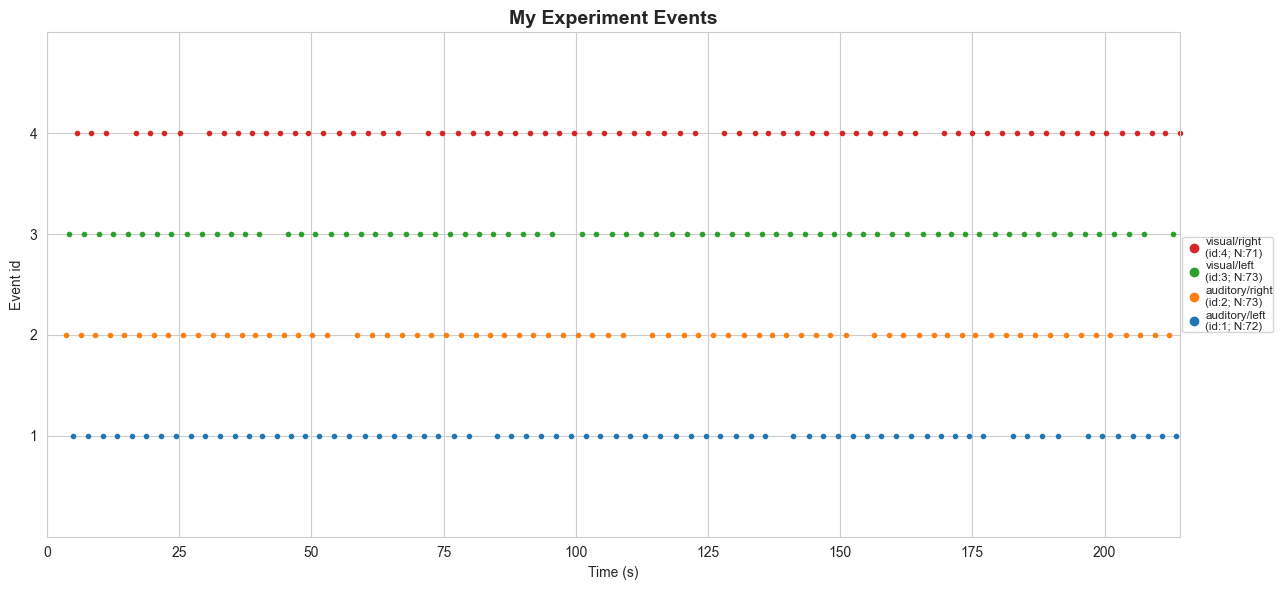

In [8]:
# Visualize events
fig = plot_events_timeline(events, raw_clean, event_id=event_id, title='My Experiment Events')

###  Create Epochs

**Epoching** segments continuous data into time-locked trials.

Key Parameters:
- `tmin, tmax`: Time window around event (-0.2 to 0.5 seconds)
- `baseline`: Period for baseline correction (-0.2 to 0 seconds)
- `reject`: Amplitude thresholds to reject bad trials

**Baseline Correction**: Removes pre-stimulus activity by subtracting the mean of the baseline period. This makes the signal relative to a zero baseline, allowing comparison across trials.

In [9]:
epochs = create_epochs(
    raw_clean,
    events=events,
    event_id=event_id,
    tmin=-0.2,  # 200ms before event
    tmax=0.5,   # 500ms after event
    baseline=(-0.2, 0),  # Baseline correction period
    reject=dict(eeg=100e-6, eog=200e-6)  # Rejection thresholds
)

print(f"\n✓ Created {len(epochs)} good epochs")
print(f"  Dropped: {epochs.drop_log_stats()}% of epochs")
print(f"  Time window: {epochs.tmin:.2f} to {epochs.tmax:.2f} seconds")
print(f"  Baseline: {epochs.baseline}")


✓ Created 226 good epochs
  Dropped: 21.79930795847751% of epochs
  Time window: -0.20 to 0.50 seconds
  Baseline: (-0.2, 0.0)


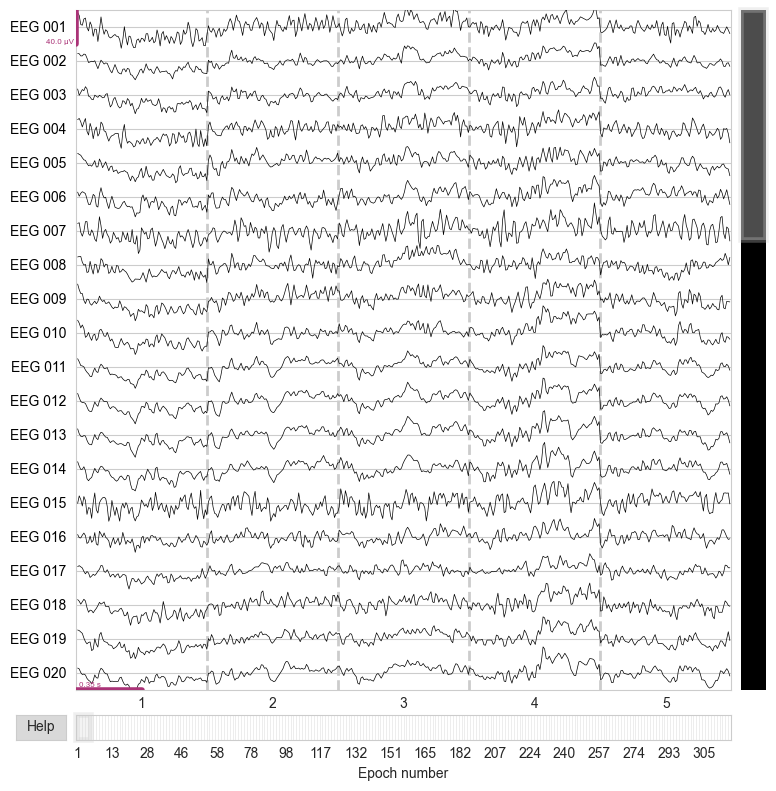

In [10]:
# Visualize epochs
epochs.plot(n_epochs=5, n_channels=20, title='Epoch Browser')
plt.show()

### Compute ERPs by Averaging

The ERP is the **average** of all epochs in a condition.

**Mathematical Formula:** 

$ERP(t) = \frac{1}{N} \sum_{i=1}^{N} x_i(t)$

Where:
- $N$ = number of trials
- $x_i(t)$ = signal at time $t$ for trial $i$

**Signal-to-Noise Ratio (SNR)**:
- Single trial SNR: 1:1 (signal buried in noise)
- After averaging N trials: SNR improves by $\sqrt{N}$
- Example: 100 trials → SNR improved by 10×

In [11]:
# Compute ERPs for each condition

evokeds = {}
for condition in event_id.keys():
    evokeds[condition] = compute_erp(epochs, condition=condition)
    print(f"  {condition}: {len(epochs[condition])} trials averaged")

  auditory/left: 51 trials averaged
  auditory/right: 59 trials averaged
  visual/left: 61 trials averaged
  visual/right: 55 trials averaged



Auditory Left ERP:


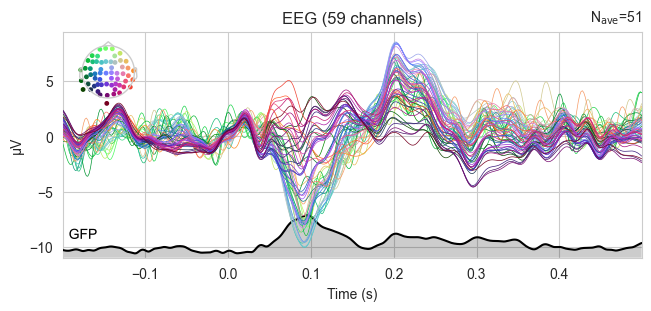

In [12]:
# Visualize auditory ERP
print("\nAuditory Left ERP:")
evokeds['auditory/left'].plot(spatial_colors=True, gfp=True)
plt.show()


Visual Left ERP:


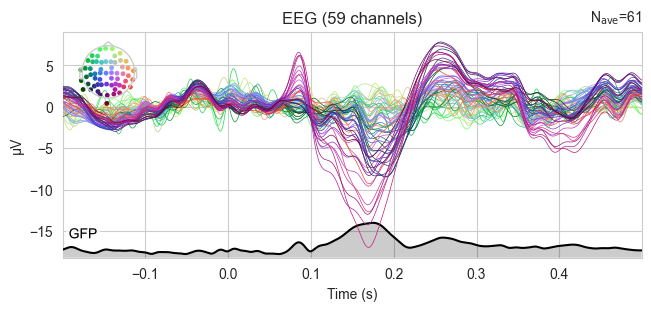

In [13]:
# Visualize visual ERP
print("\nVisual Left ERP:")
evokeds['visual/left'].plot(spatial_colors=True, gfp=True)
plt.show()

### Compare Conditions
Comparing ERPs between conditions reveals which brain regions respond differently.


Comparing auditory vs visual ERPs...


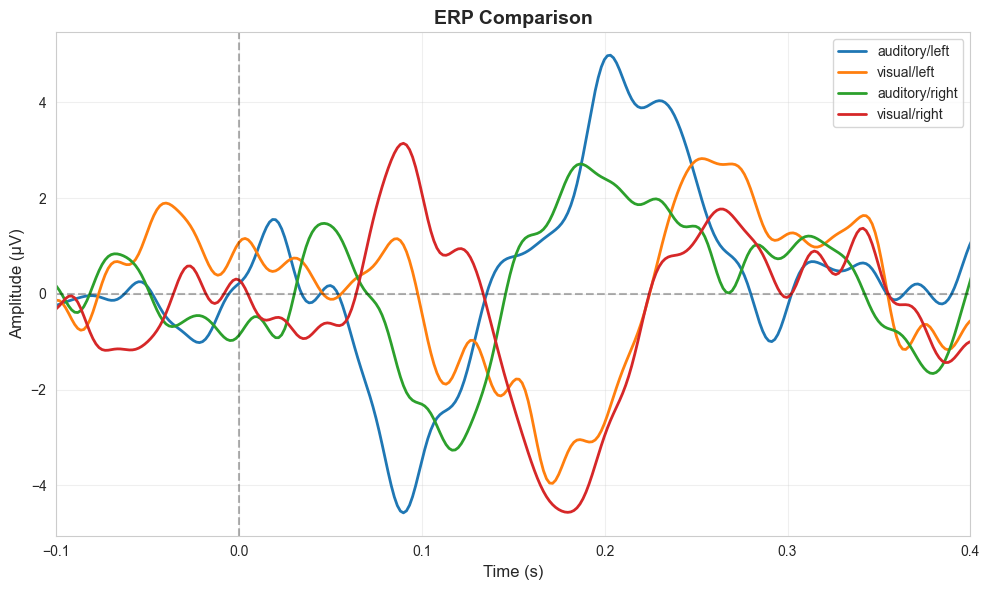

In [14]:
# Compare auditory vs visual ERPs
print("Comparing auditory vs visual ERPs...")

conditions_to_compare = ['auditory/left', 'visual/left', 'auditory/right', 'visual/right']
comparison_evokeds, fig = compare_erps(
    epochs,
    conditions=conditions_to_compare,
    channel=None,  # Average across channels
    tmin=-0.1,
    tmax=0.4
)
plt.show()

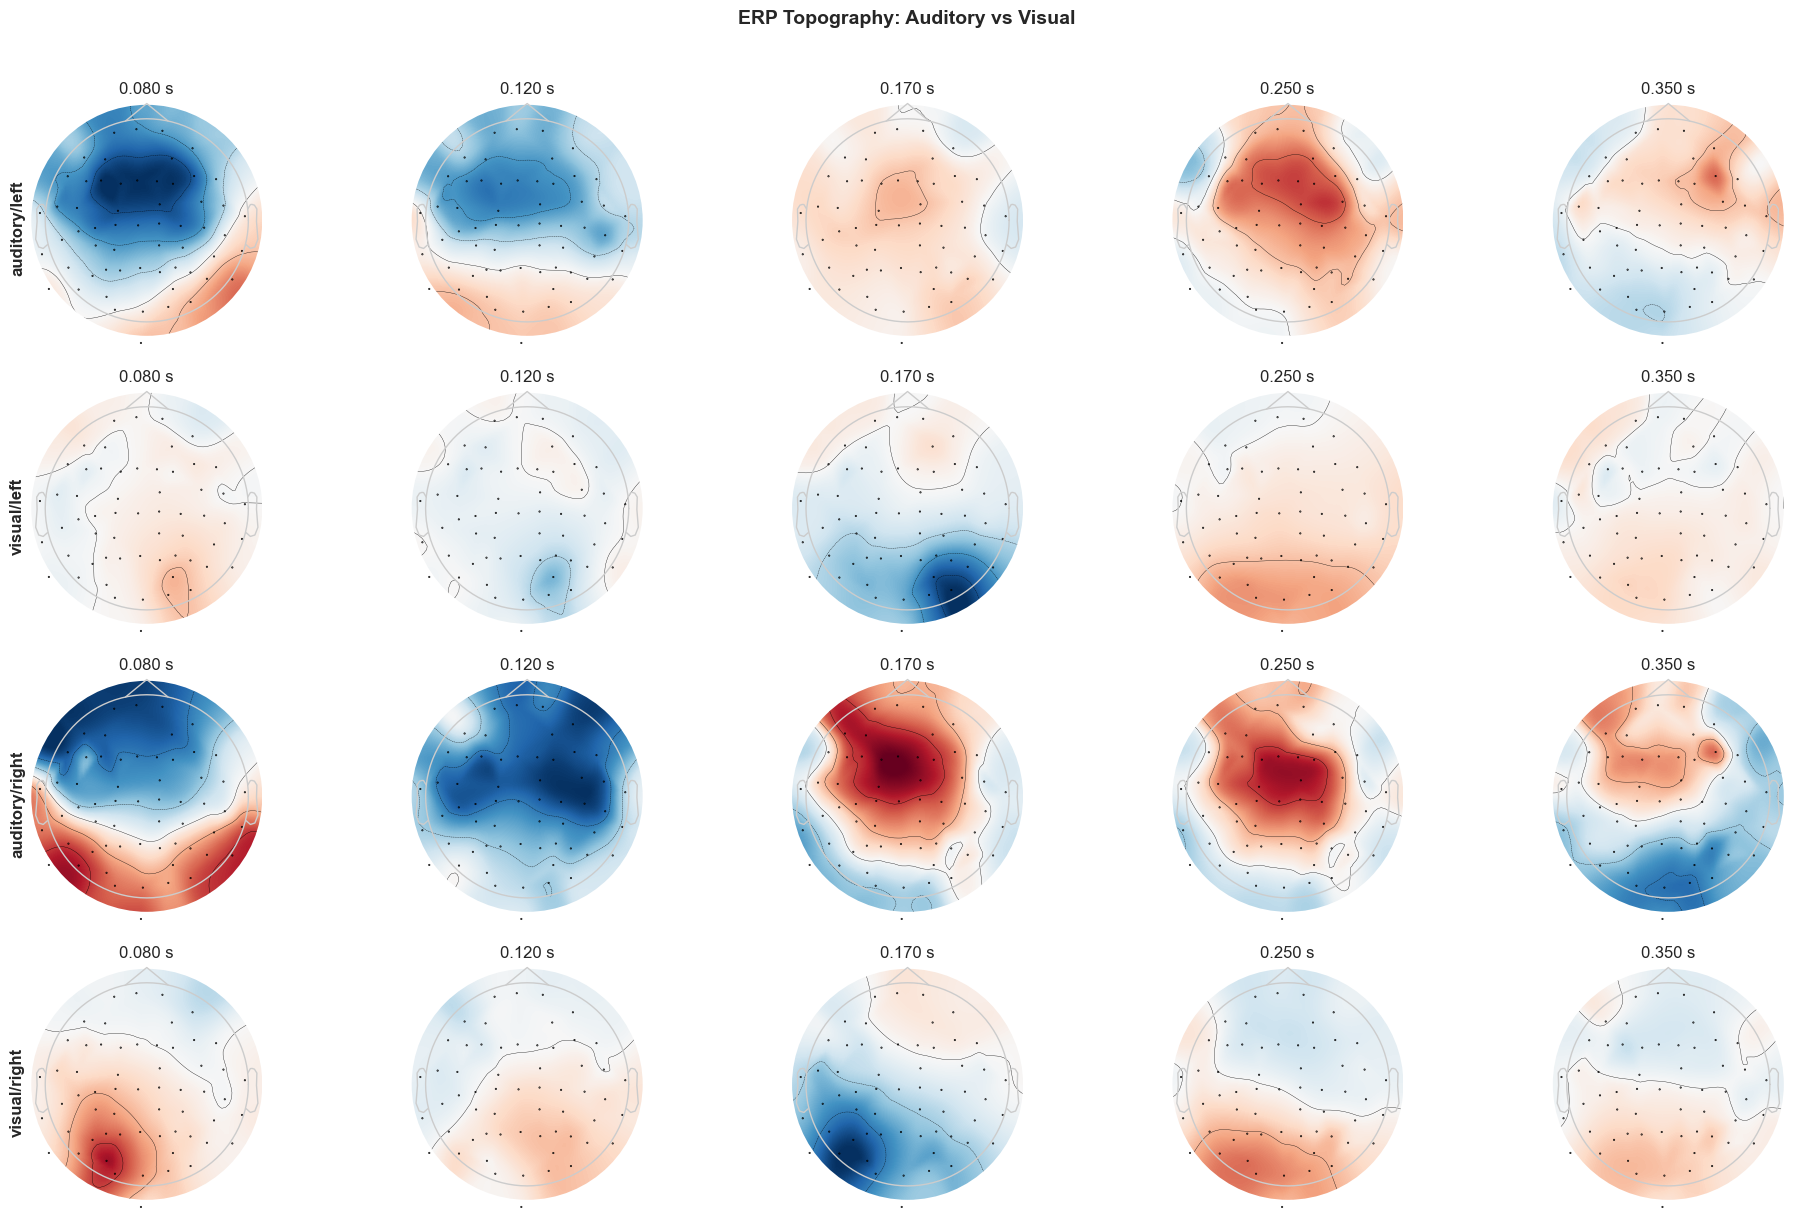

In [15]:
# Plot topographic maps at different time points
times = np.array([0.08, 0.12, 0.17, 0.25, 0.35])

fig, axes = plt.subplots(4, len(times), figsize=(20, 12))

for idx, condition in enumerate(conditions_to_compare):
    evokeds[condition].plot_topomap(
        times=times,
        axes=axes[idx],
        colorbar=False,
        show=False
    )
    axes[idx, 0].set_ylabel(condition, fontsize=12, fontweight='bold')

plt.suptitle('ERP Topography: Auditory vs Visual', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### Identify ERP Components

**ERP Components** are characteristic peaks with known functional significance:

Common Visual ERP Components:
- **P1 (80-120ms)**: Early visual processing in occipital cortex
- **N170 (150-200ms)**: Face/object recognition in temporal cortex
- **P300 (250-500ms)**: Attention, memory updating, decision making

Measurement:
- **Latency**: Time of peak (milliseconds)
- **Amplitude**: Size of peak (microvolts)
- **Topography**: Spatial distribution (which electrodes show it)

In [16]:
# Define components to measure
components = {
    'P1': {'tmin': 0.08, 'tmax': 0.12, 'mode': 'pos'},
    'N170': {'tmin': 0.15, 'tmax': 0.20, 'mode': 'neg'},
    'P300': {'tmin': 0.25, 'tmax': 0.45, 'mode': 'pos'}
}

In [17]:
posterior_channel = evokeds['visual/left'].ch_names[-1]
posterior_channel

'EEG 060'

Identifying ERP components...



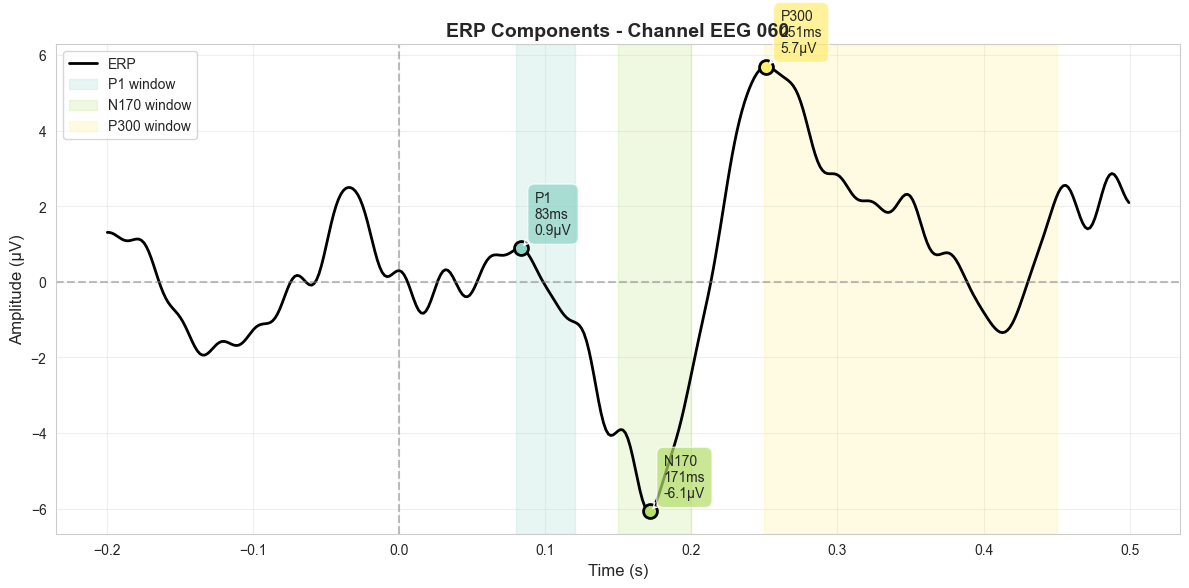

In [18]:
# Plot components for visual condition
print("Identifying ERP components...\n")


fig = plot_erp_components(
    evokeds['visual/left'],
    components=components,
    channel=posterior_channel
)
plt.show()

In [19]:
# Extract peak measurements
print("\nComponent Measurements (Visual Left, Channel Oz):")
print("="*60)

for comp_name, comp_params in components.items():
    latency, amplitude = find_peak_latency(
        evokeds['visual/left'],
        tmin=comp_params['tmin'],
        tmax=comp_params['tmax'],
        channel=posterior_channel,
        mode=comp_params['mode']
    )
    print(f"{comp_name:6s}: Latency = {latency*1000:6.1f} ms,  Amplitude = {amplitude*1e6:7.2f} µV")


Component Measurements (Visual Left, Channel Oz):
P1    : Latency =   83.2 ms,  Amplitude =    0.89 µV
N170  : Latency =  171.5 ms,  Amplitude =   -6.08 µV
P300  : Latency =  251.4 ms,  Amplitude =    5.70 µV


### Compute Difference Waves (Contrasts)

**Difference waves** isolate brain activity unique to one condition.

Formula:
$Contrast = ERP_A - ERP_B$

Example:
- Visual - Auditory = **Visual-specific** processing
- Target - Standard = **Oddball effect** (P300)

Difference waves remove shared activity (e.g., attention, motor prep) and highlight condition-specific responses.

Computing difference wave: Visual - Auditory



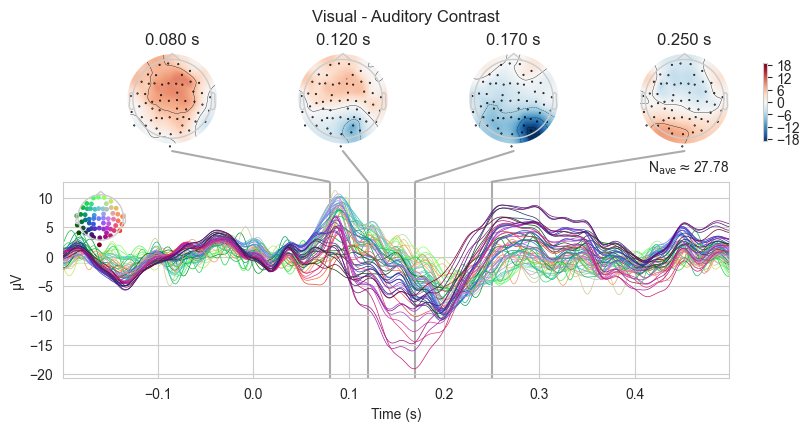

In [20]:
# Compute contrast: Visual - Auditory
print("Computing difference wave: Visual - Auditory\n")

contrast = compute_contrast(
    evokeds['visual/left'],
    evokeds['auditory/left'],
    operation='subtract'
)

# Visualize the contrast
contrast.plot_joint(
    times=[0.08, 0.12, 0.17, 0.25],
    title='Visual - Auditory Contrast'
)
plt.show()

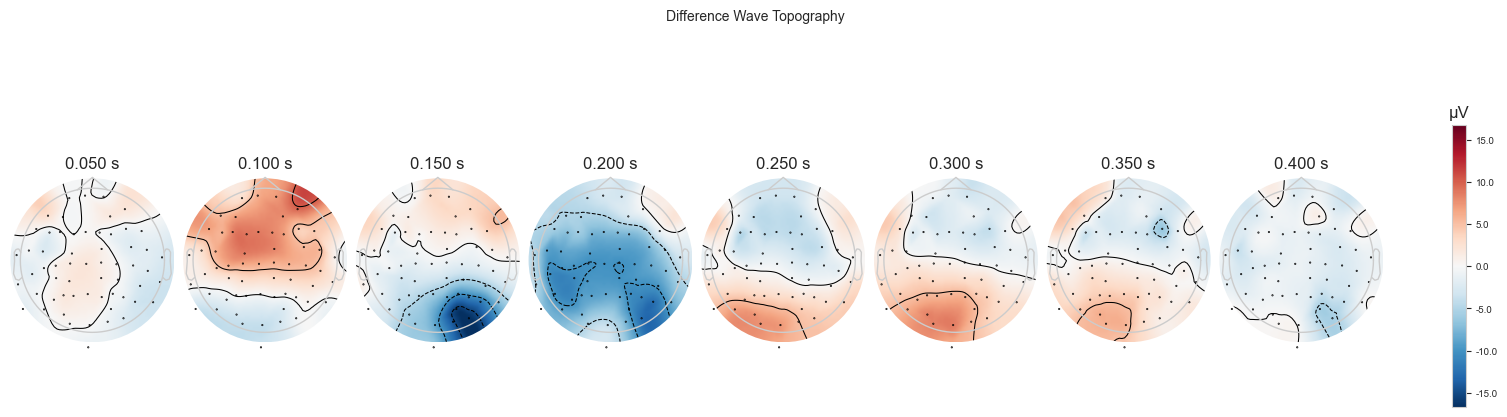

In [21]:
# Plot contrast topography
times = np.linspace(0.05, 0.4, 8)
fig = plot_meg_topomap(
    evoked=contrast,
    times=times,
    ch_type='eeg',
    colorbar=True,
    figsize=(15, 5),
    title='Difference Wave Topography'
)
plt.show()

### Statistical Testing

**The Multiple Comparisons Problem**: 

When testing many time points and channels simultaneously:
- 60 channels × 350 time points = **21,000 tests**
- At α = 0.05, we expect **1,050 false positives** by chance!

**Solution: Cluster-Based Permutation Test**

This non-parametric test:
1. Identifies **spatiotemporal clusters** (connected regions in space-time)
2. Compares cluster sizes to a **permutation distribution**
3. Controls family-wise error rate (FWER)

Advantages:
- No assumptions about data distribution
- Sensitive to sustained effects across time/space
- Controls for multiple comparisons

In [22]:
# Perform cluster-based permutation test
print("Running cluster-based permutation test...")
print("(This may take a minute...)\n")

T_obs, clusters, cluster_pv, H0 = permutation_cluster_test(
    epochs['visual/left'],
    epochs['auditory/left'],
    n_permutations=1000,
    tail=0,  # Two-tailed test
    n_jobs=1
)

Running cluster-based permutation test...
(This may take a minute...)



/Users/yibeisita/Documents/neuro-ai-playground/tutorials/03_time_domain/../../neurolib/eeg_meg/analysis.py:209: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  T_obs, clusters, cluster_pv, H0 = permutation_cluster_test(
/Users/yibeisita/Documents/neuro-ai-playground/.venv/lib/python3.11/site-packages/mne/stats/parametric.py:171: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/Users/yibeisita/Documents/neuro-ai-playground/.venv/lib/python3.11/site-packages/mne/stats/parametric.py:171: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/yibeisita/Documents/neuro-ai-playground/tutorials/03_time_domain/../../neurolib/eeg_meg/analysis.py:209: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  T_obs, clusters, cluster_pv, H0 = permutation_cluster_test(
/Users/yibeisita/Documents/neuro-ai-playground/.venv/lib/python3.11/site-packages/mne/stats/parametric.py:171: RuntimeWar

In [23]:
# Report results
print(f"✓ Test complete!\n")
print(f" Statistical Results:")
print(f"  Total clusters found: {len(clusters)}")
print(f"  Significant clusters (p < 0.05): {np.sum(cluster_pv < 0.05)}\n")

✓ Test complete!

 Statistical Results:
  Total clusters found: 102
  Significant clusters (p < 0.05): 5



In [24]:
# Visualize significant clusters
for i, cluster in enumerate(clusters):
    cluster_mask = cluster[0]  # MNE cluster mask

    tmin, tmax = extract_cluster_time_window(cluster_mask, epochs.times)

    if tmin is None:
        print(f"Cluster {i+1}: skipped (no temporal extent)")
    else:
        print(f"Cluster {i+1}: {tmin:.3f}–{tmax:.3f} sec")


Cluster 1: -0.200–-0.186 sec
Cluster 2: -0.200–-0.186 sec
Cluster 3: -0.200–0.499 sec
Cluster 4: -0.200–-0.173 sec
Cluster 5: -0.200–0.083 sec
Cluster 6: -0.200–-0.193 sec
Cluster 7: -0.200–-0.190 sec
Cluster 8: -0.200–-0.193 sec
Cluster 9: -0.200–-0.198 sec
Cluster 10: -0.200–-0.195 sec
Cluster 11: -0.200–-0.188 sec
Cluster 12: -0.200–-0.188 sec
Cluster 13: -0.200–-0.180 sec
Cluster 14: -0.200–-0.196 sec
Cluster 15: -0.200–-0.173 sec
Cluster 16: -0.200–-0.190 sec
Cluster 17: -0.200–0.499 sec
Cluster 18: -0.200–-0.198 sec
Cluster 19: -0.200–-0.196 sec
Cluster 20: -0.200–-0.176 sec
Cluster 21: -0.200–-0.188 sec
Cluster 22: -0.200–-0.190 sec
Cluster 23: -0.200–-0.195 sec
Cluster 24: -0.200–-0.196 sec
Cluster 25: -0.200–-0.195 sec
Cluster 26: -0.200–-0.176 sec
Cluster 27: -0.200–-0.191 sec
Cluster 28: -0.200–-0.190 sec
Cluster 29: -0.200–-0.191 sec
Cluster 30: -0.200–-0.180 sec
Cluster 31: -0.200–-0.200 sec
Cluster 32: -0.200–-0.193 sec
Cluster 33: -0.200–-0.193 sec
Cluster 34: -0.200–-0.

### Extract Features for Further Analysis

For statistical analysis (ANOVA, t-tests, regression), we often need to extract **numerical features** from ERPs:

- **Mean amplitude** in a time window
- **Peak amplitude** and **latency**
- **Area under the curve**

These features can then be exported and analyzed in other software (R, SPSS, etc.).

In [28]:
# Define time windows for feature extraction
time_windows = {
    'P1': (0.08, 0.12),
    'N170': (0.15, 0.20),
    'P300': (0.25, 0.45)
}

In [ ]:
# Select the 3 most posterior EEG channels based on their location
ev = evokeds['visual/left']
print(ev.ch_names)
picks = mne.pick_types(ev.info, eeg=True)
ch_locs = np.array([ev.info['chs'][p]['loc'][:3] for p in picks])
sorted_idx = np.argsort(ch_locs[:, 1]) 
selected = [ev.ch_names[picks[i]] for i in sorted_idx[:3]]
print(selected)


['EEG 001', 'EEG 002', 'EEG 003', 'EEG 004', 'EEG 005', 'EEG 006', 'EEG 007', 'EEG 008', 'EEG 009', 'EEG 010', 'EEG 011', 'EEG 012', 'EEG 013', 'EEG 014', 'EEG 015', 'EEG 016', 'EEG 017', 'EEG 018', 'EEG 019', 'EEG 020', 'EEG 021', 'EEG 022', 'EEG 023', 'EEG 024', 'EEG 025', 'EEG 026', 'EEG 027', 'EEG 028', 'EEG 029', 'EEG 030', 'EEG 031', 'EEG 032', 'EEG 033', 'EEG 034', 'EEG 035', 'EEG 036', 'EEG 037', 'EEG 038', 'EEG 039', 'EEG 040', 'EEG 041', 'EEG 042', 'EEG 043', 'EEG 044', 'EEG 045', 'EEG 046', 'EEG 047', 'EEG 048', 'EEG 049', 'EEG 050', 'EEG 051', 'EEG 052', 'EEG 054', 'EEG 055', 'EEG 056', 'EEG 057', 'EEG 058', 'EEG 059', 'EEG 060']
['EEG 060', 'EEG 058', 'EEG 059']


In [34]:
# Extract features for visual condition
print("Extracting ERP features...\n")

features = extract_erp_features(
    evokeds['visual/left'],
    time_windows=time_windows,
    channels=selected
)

Extracting ERP features...



In [35]:
# Convert to DataFrame for easy viewing
feature_df = pd.DataFrame(features).T
feature_df.index.name = 'Component_Channel'

print("Extracted Features:")
print("="*80)
print(feature_df.to_string())

Extracted Features:
                   mean_amplitude  peak_amplitude  peak_latency
Component_Channel                                              
P1_EEG 060          -1.030155e-07        0.000001      0.119877
P1_EEG 058          -1.352901e-06        0.000004      0.113217
P1_EEG 059          -5.677715e-07        0.000006      0.119877
N170_EEG 060        -4.676654e-06        0.000006      0.171491
N170_EEG 058        -6.475463e-06        0.000008      0.169826
N170_EEG 059        -1.043864e-05        0.000013      0.168161
P300_EEG 060         1.758211e-06        0.000006      0.251409
P300_EEG 058         2.341444e-06        0.000007      0.253074
P300_EEG 059         4.247323e-07        0.000007      0.253074


### Summary
- ERPs require many trials (20-100+) for good SNR  
- Baseline correction removes pre-stimulus differences  
- Component measurement requires careful time window selection  
- Statistical testing must account for multiple comparisons  
- Topographic visualization shows spatial distribution  